# <center>NBA Outcome Predictor</center>

## Choose your match up

In [1]:
#Import Everything here 
from ipywidgets import widgets
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import ipython_blocking
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from datetime import datetime, timedelta
from IPython.display import  Markdown, Javascript, display
from ipywidgets import widgets

plt.style.use('ggplot')
ipython_blocking.load_ipython_extensions()


In [2]:
#All Functions in this block
def prediction_model_run(b):
    display(Javascript('IPython.notebook.execute_cells_below()'))

def printmd(string):
    display(Markdown(string))
    
def name_winning_team(row):
    if(row.VisitorPoints > row.HomePoints):
        return row['VisitorTeam']
    else:
        return row['HomeTeam']
    
def winning_team_prediction(x):
    if(x):
        return home_team.value
    else:
        return away_team.value

    
#This method below finds the rankings of the visitor team and the home team and visitor team
#and sets the row to true if home team ranks higher else false.
def home_team_rankings_higher(row):
    home_team  = row['HomeTeam']
    visitor_team = row['VisitorTeam']
    home_rank = rankings_df.loc[home_team]['Rk']
    visitor_rank = rankings_df.loc[visitor_team]['Rk']
    return home_rank < visitor_rank #the lower the rank the higher you are thats why hometeam < visitor

    
#This method below finds teams per game stats that is still in the works like FG%, 3P%, Assist
#And Compares them to the opponents and if its higher then it will be true else false
def home_team_field_goal_percent_higher(row, column_name):
    home_team  = row['HomeTeam']
    visitor_team = row['VisitorTeam']
    home_fg_percentage = team_per_game_stats_df.loc[home_team][column_name]
    visitor_fg_percentage = team_per_game_stats_df.loc[visitor_team][column_name]
    return home_fg_percentage > visitor_fg_percentage


def home_team_per_assist_turnover_ratio_higher(row):
    home_team  = row['HomeTeam']
    visitor_team = row['VisitorTeam']
    home_assist_turnover_ratio = team_per_game_stats_df.loc[home_team]['AST'] / team_per_game_stats_df.loc[home_team]['TOV']
    visitor_assist_turnover_ratio = team_per_game_stats_df.loc[visitor_team]['AST'] / team_per_game_stats_df.loc[visitor_team]['TOV']
    return home_assist_turnover_ratio > visitor_assist_turnover_ratio 


In [3]:
#Getting All the Files we need to make predictions

#This fixes the date to be in the correct format while reading the file in
box_scores_df = pd.read_csv('data/2018_2019BoxScores.csv', parse_dates=['Date'])

#This grabs the files for other stats for teams
rankings_df = pd.read_csv('data/NBAExpandedStandings2018_2019.csv', skiprows=[0], index_col='Team')
team_per_game_stats_df = pd.read_csv('data/TeamPerGameStats2018_2019.csv', index_col='Team')


#Renaming Columns to have them make more sense 
box_scores_df.columns = ['Date', 'StartTime', 'VisitorTeam', 'VisitorPoints',
              'HomeTeam', 'HomePoints', 'ScoreType', 'OT', 'Attendance','Notes']

#Getting basic true false if home team won or lost
box_scores_df['HomeWins'] = box_scores_df['HomePoints'] > box_scores_df['VisitorPoints']
y_true = box_scores_df['HomeWins'].values



In [4]:
away_team = widgets.Dropdown(
    options = list(team_per_game_stats_df.index.values),
    description='Away Team:',
    value='Golden State Warriors',
    disabled=False,
)

home_team = widgets.Dropdown(
    options= list(team_per_game_stats_df.index.values),
    description='Home Team:',
    value='Houston Rockets',
    disabled=False,
)

run_prediction = widgets.Button(description='Run Predictions')



In [18]:
display(home_team)
display(away_team)
display(run_prediction)

run_prediction.on_click(prediction_model_run)


<IPython.core.display.Javascript object>

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [19]:
#%block run_prediction

In [20]:
d = {'Rk': [rankings_df.loc[home_team.value]['Rk'], rankings_df.loc[away_team.value]['Rk']],
     'FG%': [team_per_game_stats_df.loc[home_team.value]['FG%'], team_per_game_stats_df.loc[away_team.value]['FG%']],
     '3P%': [team_per_game_stats_df.loc[home_team.value]['3P%'], team_per_game_stats_df.loc[away_team.value]['3P%']],
     'PPG': [team_per_game_stats_df.loc[home_team.value]['PTS'], team_per_game_stats_df.loc[away_team.value]['PTS']],
     'AssistTurnoverRatio' : [team_per_game_stats_df.loc[home_team.value]['AST'] / team_per_game_stats_df.loc[home_team.value]['TOV'], team_per_game_stats_df.loc[away_team.value]['AST'] / team_per_game_stats_df.loc[away_team.value]['TOV']],
    }

results_df = pd.DataFrame(data=d, index=[home_team.value, away_team.value])

## Team Comparisons


In [21]:
if home_team.value != away_team.value :
    printmd('Factors used to Predict Outcome')
    display(results_df.style\
    .highlight_max(subset=['3P%','AssistTurnoverRatio','FG%','PPG'] , color='lightgreen')\
    .highlight_min(subset=['Rk'], color='lightgreen'))

Factors used to Predict Outcome

,3P%,AssistTurnoverRatio,FG%,PPG,Rk
Boston Celtics,0.36,1.96875,0.452,111.6,7
Houston Rockets,0.346,1.54015,0.448,109.8,10


## Previous Game Results

In [22]:
previous_matchups = box_scores_df.loc[box_scores_df['HomeTeam'].isin({home_team.value,away_team.value}) 
                  & box_scores_df['VisitorTeam'].isin({home_team.value,away_team.value})]

previous_matchups = previous_matchups[['Date','VisitorPoints', 'VisitorTeam','HomeTeam', 'HomePoints']]
if(len(previous_matchups) > 0):
    previous_matchups['Winner'] = previous_matchups.apply(name_winning_team, axis = 1)


In [23]:
previous_matchups

,Date,VisitorPoints,VisitorTeam,HomeTeam,HomePoints,Winner
512,2018-12-27,113,Boston Celtics,Houston Rockets,127,Houston Rockets


In [24]:
matchup_data = {
    'HomeTeamRanksHigher': [(results_df.loc[home_team.value]['Rk'] < results_df.loc[away_team.value]['Rk'])],
    'HomeTeamPTSHigher': [results_df.loc[home_team.value]['PPG'] > results_df.loc[away_team.value]['PPG']],
    'HomeTeamFG%Higher': [(results_df.loc[home_team.value]['FG%'] > results_df.loc[away_team.value]['FG%'])],
    'HomeTeamAssistTurnOverRatioHigher': [(results_df.loc[home_team.value]['AssistTurnoverRatio'] > results_df.loc[away_team.value]['AssistTurnoverRatio'])],
    'HomeTeam3P%Higher': [(results_df.loc[home_team.value]['3P%'] > results_df.loc[away_team.value]['3P%'])]
}
                 
predictions_X = pd.DataFrame(data=matchup_data)

## Team Wins and Losses By Month

Data Showing wins and losses graphed by month but not a factor in prediction

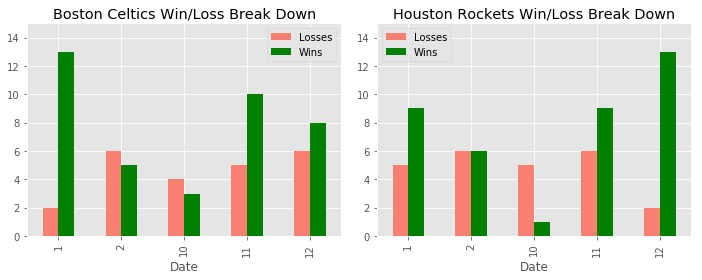

In [25]:
fig, ax = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns

home_team_history = box_scores_df.loc[box_scores_df['HomeTeam'].isin({home_team.value}) | box_scores_df['VisitorTeam'].isin({home_team.value})]
x = home_team_history['Date'].groupby([home_team_history.Date.dt.month, home_team_history.HomeWins]).agg('count')
x.unstack().plot(kind='bar', stacked=False, color=['salmon', 'green'], ax=ax[0])  
plt.title(home_team.value + " Break Down") # This seems to be identical to ax.set_title
ax[0].set_title(home_team.value + " Win/Loss Break Down")
ax[0].legend(["Losses", "Wins"]);
ax[0].set_ylim(0,15)

away_team_history = box_scores_df.loc[box_scores_df['HomeTeam'].isin({away_team.value}) | box_scores_df['VisitorTeam'].isin({away_team.value})]
y = away_team_history['Date'].groupby([away_team_history.Date.dt.month, away_team_history.HomeWins]).agg('count')
y.unstack().plot(kind='bar', stacked=False, color=['salmon', 'green'],ax=ax[1])  
ax[1].set_title(away_team.value + " Win/Loss Break Down")
ax[1].legend(["Losses", "Wins"]);
ax[1].set_ylim(0,15)
printmd('Data Showing wins and losses graphed by month but not a factor in prediction')
plt.tight_layout()
plt.show()




## <center>Game Win Prediction</center>


In [26]:
#Getting all stats for predictions

box_scores_df['HomeTeamRanksHigher'] = box_scores_df.apply(home_team_rankings_higher, axis = 1)
box_scores_df['HomeTeamFG%Higher'] = box_scores_df.apply(home_team_field_goal_percent_higher, args=('FG%',) ,axis = 1)
box_scores_df['HomeTeam3P%Higher'] = box_scores_df.apply(home_team_field_goal_percent_higher, args=('3P%',) ,axis = 1)
box_scores_df['HomeTeamPTSHigher'] = box_scores_df.apply(home_team_field_goal_percent_higher, args=('PTS',) ,axis = 1)
box_scores_df['HomeTeamAssistTurnOverRatioHigher'] = box_scores_df.apply(home_team_per_assist_turnover_ratio_higher, axis = 1)

#This gets the Away Team and if they had a back to back away Game
#Line commented below can be used later to get the number of days of rest
#df['VisitorRest'] =  df.groupby(['VisitorTeam'])['Date'].diff() - timedelta(days=1) 
visitor_rest_holder = box_scores_df.groupby(['VisitorTeam'])['Date'].diff() - timedelta(days=1)  == timedelta(days=0)
box_scores_df['VisitorBackToBack'] = visitor_rest_holder


In [27]:
#This is the predictor variable 
#RENAME THIS
X_features = box_scores_df[['HomeTeamRanksHigher', 'HomeTeamPTSHigher','HomeTeamFG%Higher', 'HomeTeamAssistTurnOverRatioHigher','HomeTeam3P%Higher']]


In [28]:
strat_k_fold = StratifiedKFold(n_splits=10, random_state=10)

# Specify parameters
c_values = list(np.arange(1, 10))
param_grid = [
    {'C': c_values, 'penalty': ['l1'], 'solver' : ['liblinear'], 'multi_class' : ['ovr']},
    {'C': c_values, 'penalty': ['l2'], 'solver' : ['liblinear', 'newton-cg', 'lbfgs'], 'multi_class' : ['ovr']}
]

grid = GridSearchCV(LogisticRegression(), param_grid, cv=strat_k_fold, scoring='accuracy', iid=False)
grid.fit(X_features, y_true)
print(grid.best_score_)

0.672191718142


In [29]:
result = grid.predict(predictions_X)

In [30]:
winning_team = winning_team_prediction(result[0])
printmd('<h2 style="color:Red;"><center>Winner of Game --- {}</center></h2>'.format(winning_team_prediction(result[0])))


<h2 style="color:Red;"><center>Winner of Game --- Boston Celtics</center></h2>